# Secret Manager Function

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

# Connecting to Database

In [31]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

# Q1

In [3]:
import warnings

warnings.simplefilter('ignore')

## Pull fips for state

In [4]:
import pandas as pd

sql_fips = """
SELECT fips, name
FROM name
WHERE name = 'New York';
"""

ny_fips = pd.read_sql(sql_fips, conn)
print(ny_fips)


  fips      name
0   36  New York


## Pull yearly population data

In [5]:
sql_population_fips = f"""
SELECT year, pop
FROM population
WHERE fips = '36'
ORDER BY year ASC;
"""

ny_df = pd.read_sql(sql_population_fips, conn)
ny_df.head()


,year,pop
0,2005,18655275
1,2006,19306183
2,2007,19297729
3,2008,19490297
4,2009,19541453


## Use Jupyter AI to calculate and plot growth rate

In [6]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install "jupyter-ai-magics[all]" -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai_1')['api_key']

In [10]:
%load_ext jupyter_ai_magics

In [11]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {ny_df}, use the ny_df directly, and visualize the result on a line chart

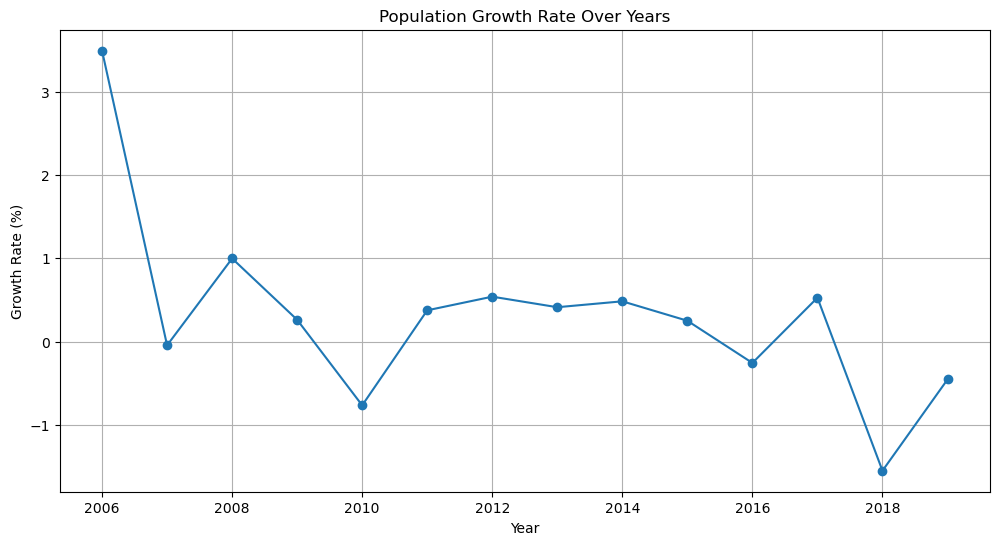

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in dataframe named "ny_df"

ny_df['pop_shift'] = ny_df['pop'].shift(1)
ny_df['growth_rate'] = (ny_df['pop'] - ny_df['pop_shift']) / ny_df['pop_shift']*100
ny_df.dropna(inplace=True)

plt.figure(figsize=(12,6))
plt.plot(ny_df['year'], ny_df['growth_rate'], marker = 'o')
plt.title('Population Growth Rate Over Years')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid()
plt.show()

#This code calculates the growth rate from one year to another considering the population of the previous year in the "ny_df" dataframe, then it plots the growth rate in the form of a line chart. It uses 'pop_shift' as a temporary column so this code assumes there isn't any column named 'pop_shift' in the provided data.

The graph shows the population growth rate by year starting from 2006. 2018 had the lowest growth rate in the graph, at roughly -1.5%. The highest growth rate was in 2006, at roughly 3.6%.

# Q2

## SQL query to join income and population

In [13]:
query = """
SELECT n.name, i.year, i.income, p.pop
FROM income AS i
JOIN population AS p
    ON i.fips = p.fips AND i.year = p.year
JOIN name AS n
    ON i.fips = n.fips
WHERE i.fips = '36'
ORDER BY i.year;
"""
df_q2 = pd.read_sql(query, conn)

## Visualization

In [14]:
%%ai gpt4 -f code 
create a dual-axis chart in Python using the data provided in {df_q2}. x axis should be year, left y axis should be population (line), and right y axis should be median household income (line). The chart needs to include New York in the title. 

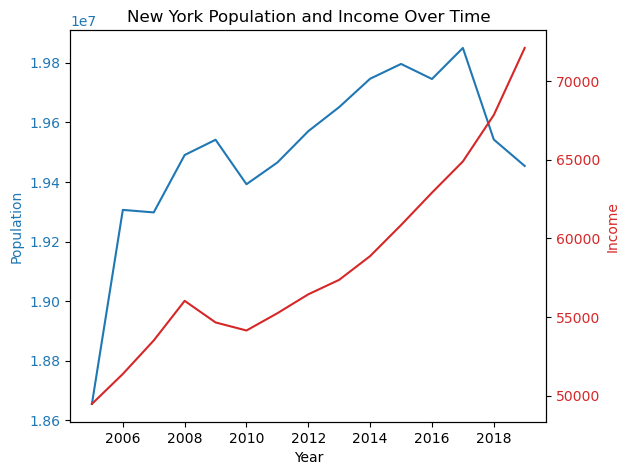

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'name': ['New York']*15,
    'year': list(range(2005, 2020)),
    'income': [49480, 51384, 53514, 56033, 54659, 54148, 55246, 56448, 57369, 58878, 60850, 62909, 64894, 67844, 72108],
    'pop': [18655275, 19306183, 19297729, 19490297, 19541453, 19392283, 19465197, 19570261, 19651127, 19746227, 19795791, 19745289, 19849399, 19542209, 19453561]
}

df_q2 = pd.DataFrame(data)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(df_q2['year'], df_q2['pop'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Income', color=color)  
ax2.plot(df_q2['year'], df_q2['income'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('New York Population and Income Over Time')
plt.show()

Population and income trends are mostly similar throughout the years, with income increasing as population increases and the same for decreasing. The only anomoly is in 2018, where income continued to increase despite population decreasing. 

# Q3

## Question

How has the per capita income (income ÷ population) in New York changed over time?

## SQL Query

In [25]:
query_q3 = """
SELECT 
    i.year,
    i.income::numeric / p.pop AS per_capita_income
FROM income AS i
JOIN population AS p
    ON i.fips = p.fips AND i.year = p.year
WHERE i.fips = '36'
ORDER BY i.year;
"""

df_q3 = pd.read_sql(query_q3, conn)

In [26]:
%%ai gpt4 -f code 
create a line chart using the data in {df_q3} for per capita income. Ensure the state name (New York) is in the title of the chart. X axis should be year, y axis should be Per Capita Income.

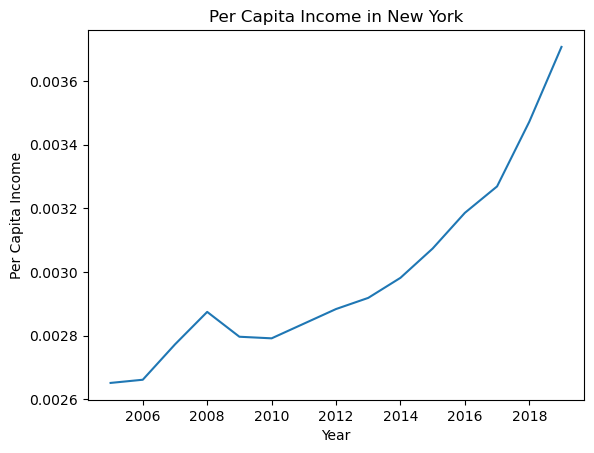

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "year": [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    "per_capita_income": [0.002652, 0.002662, 0.002773, 0.002875, 0.002797, 0.002792, 0.002838, 0.002884, 0.002919, 0.002982, 0.003074, 0.003186, 0.003269, 0.003472, 0.003707]
}

df = pd.DataFrame(data)

plt.plot(df['year'], df['per_capita_income'])
plt.title('Per Capita Income in New York')
plt.xlabel('Year')
plt.ylabel('Per Capita Income')
plt.show()

The chart above is a line chart for the per capita income (income/population) in New York from 2005 to 2019. Per capita in New York is increasing. There was a peak in 2008, however the per capita income has continued to increase and reached its highest in 2019. 

In [33]:
#closing connection and cursor
conn.close()